# Import Libraries

In [1]:
import pandas as pd
import geopandas as gpd
import fiona
import geopandas.geoseries  
import folium
import plotly.express as px
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as ctx
from shapely import wkt
import esda
from esda.moran import Moran, Moran_Local
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation
import libpysal as lps
import contextily as cx
import imageio

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


# Doing all years 

In [2]:
# Import Data
jh2011=pd.read_csv('data/jh2011.csv')
jh2012=pd.read_csv('data/jh2012.csv')
jh2013=pd.read_csv('data/jh2013.csv')
jh2014=pd.read_csv('data/jh2014.csv')
jh2015=pd.read_csv('data/jh2015.csv')
jh2016=pd.read_csv('data/jh2016.csv')
jh2017=pd.read_csv('data/jh2017.csv')
jh2018=pd.read_csv('data/jh2018.csv')
jh2019=pd.read_csv('data/jh2019.csv')


In [3]:
# Make sure columns match
jh2019.rename(columns={'Number of Jobs Per Unit of Housing':'jobsperunithousing',
                       'Number of Jobs':'total_jobs_count',
                       'Units of Housing':'housing_units_count'},inplace=True)
jh2019['Year']='2019'
jh2013.head()


,Unnamed: 0,Neighborhood,geometry,geoid20,housing_units_count,OBJECTID,ShapeSTArea,ShapeSTLength,Year,total_jobs_count,jobsperunithousing
0,0,Adams-Normandie,"POLYGON ((-118.305408 34.025711999124255, -118...",66409439227,11696.0,8278.0,5.194088e+07,107582.924663,2013.0,1499.32,0.128191
1,1,Arleta,POLYGON ((-118.43578622489046 34.2298735046344...,84519667245,14411.0,2078.0,1.977866e+08,226887.739091,2013.0,2202.11,0.152808
2,2,Arlington Heights,POLYGON ((-118.33380900000002 34.0350109991241...,78483820162,15999.0,9240.0,7.472264e+07,137728.457729,2013.0,2508.86,0.156814
3,3,Atwater Village,POLYGON ((-118.27050800000009 34.1215079991231...,72447729825,18305.0,11452.0,3.720516e+08,286349.733482,2013.0,8028.72,0.438608
4,4,Baldwin Hills/Crenshaw,POLYGON ((-118.36503589102983 34.0055609073337...,126784467665,34478.0,24429.0,2.715788e+08,350832.124002,2013.0,6211.40,0.180155


In [4]:
# Create list of dataframes
jhlist1=[jh2011,
jh2012,
jh2013,
jh2014,
jh2015,
jh2016,
jh2017,
jh2018]

# change year to string for all dfs
for jh in jhlist1:
   
    jh['Year'] =  jh['Year'].astype(str)
    jh['Year'] =  jh['Year'].str.rstrip('.0')
    

In [5]:
# list including 2019
jhlist=[jh2011,
jh2012,
jh2013,
jh2014,
jh2015,
jh2016,
jh2017,
jh2018,
jh2019]



In [6]:
# Dropping null values (this is important for the autocorrelaion)
jh2011=jh2011.dropna()
jh2012=jh2012.dropna()
jh2013=jh2013.dropna()
jh2014=jh2014.dropna()
jh2015=jh2015.dropna()
jh2016=jh2016.dropna()
jh2017=jh2017.dropna()
jh2018=jh2018.dropna()
jh2019=jh2019.dropna()

In [7]:
# Defining function to convert to geodataframes
def addgeo(jh):
    jh['geometry'] = jh['geometry'].apply(wkt.loads)
    jh = gpd.GeoDataFrame(jh, crs="EPSG:4326",geometry='geometry')
    jh = jh.to_crs(3857)
    return jh
    

In [8]:
# running the function
jh2011=addgeo(jh2011)
jh2012=addgeo(jh2012)
jh2013=addgeo(jh2013)
jh2014=addgeo(jh2014)
jh2015=addgeo(jh2015)
jh2016=addgeo(jh2016)
jh2017=addgeo(jh2017)
jh2018=addgeo(jh2018)
jh2019=addgeo(jh2019)

/tmp/ipykernel_127/3297003038.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jh['geometry'] = jh['geometry'].apply(wkt.loads)


In [9]:
# creating a dictionary of dataframes to run through the final function later
jhdict={0:jh2011,
1:jh2012,
2:jh2013,
3:jh2014,
4:jh2015,
5:jh2016,
6:jh2017,
7:jh2018,
8:jh2019}

<AxesSubplot: >

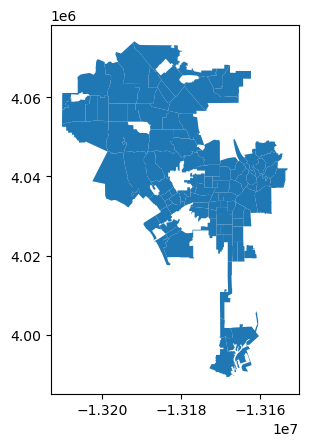

In [10]:
# confirming that the dfs successfully added geometries
jh2011.plot()

In [11]:
 # creating lists for gif function below 
frames = []
time=[0,1,2,3,4,5,6,7,8]

# Autocorrelation Function

In [12]:
def autocorrelate(key,jh=jh2011):
# calculate spatial weight
    wq =  lps.weights.KNN.from_dataframe(jh,k=8)

    # Row-standardization
    wq.transform = 'r'

    # create a new column for the spatial lag
    jh['Number_jobs_div_Housing_Lag'] = lps.weights.lag_spatial(wq, jh['jobsperunithousing'])

    # create a column that calculates the difference between arrests and lag
    jh['JH_lag_diff'] = jh['jobsperunithousing'] - jh['Number_jobs_div_Housing_Lag']
  
    # output to get the head and tail
    jh.sort_values(by='JH_lag_diff')
    
    jh.set_index
    y = jh['Number_jobs_div_Housing_Lag']
    moran = Moran(y, wq)
    moran.I
    
    moran.p_sim
   
    lisa = esda.moran.Moran_Local(y, wq)
    
    # create the 1x2 subplots
    fig, ax = plt.subplots(1, 2, figsize=(20, 12))

# regular count map on the left
    lisa_cluster(lisa, jh, p=0.05, ax=ax[0])

    ax[0].axis("off")
    ax[0].set_title('Housing/Jobs Imbalance Autocorrelation'+':'+jh['Year'].iloc[0]+', '+'P-value: 0.05')

# spatial lag map on the right
    lisa_cluster(lisa, jh, p=0.01, ax=ax[1])
    ax[1].axis("off")
    ax[1].set_title("Housing/Jobs Imbalance Autocorrelation"+":"+jh['Year'].iloc[0]+', '+"P-value: 0.01")
    cx.add_basemap(ax[0],source=cx.providers.CartoDB.Positron)
    cx.add_basemap(ax[1],source=cx.providers.CartoDB.Positron)

   
    plt.savefig(f'./autoc{key}.png')    
    plt.close()
    
  

In [13]:
# Runs my dictionary of dataframes through my function and saves the outputs as static images
for key,v in jhdict.items(): 
    autocorrelate(key,v)

# Making a GIF

In [14]:
# appends the images to a list 
for t in time:
    image = imageio.v2.imread(f'autoc{t}.png')
    frames.append(image)
# tells imageio to take that list and turn it into a gif   
imageio.mimsave('HJAutocorrelation.gif', # output gif
                frames,          # array of input frames
                fps = 1)         # optional: frames per second

# Victor and Shweta Use This One

make suer that all of the column names/titles match up with what you want them to be/what's in your dataframe. If it's in string below you probably need to change it.

## Add Neighborhood Lines

<AxesSubplot: >

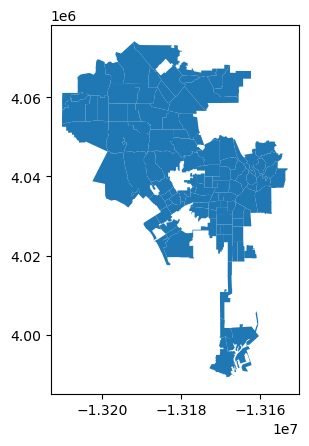

In [15]:
# Create Neighborhoods Layer

    
#Import neighborhood shapes
url = "https://usc.data.socrata.com/api/geospatial/r8qd-yxsr?method=export&format=GeoJSON"
nhoods=gpd.read_file(url,crs='EPSG:4326')
nhoods=nhoods.to_crs('EPSG:3857')
# rename neighborhood column, set index
nhoods=nhoods.rename(columns={'name':'Neighborhood'})
#drop shapes not in city of LA
nhoods.drop(nhoods[nhoods['type'] != 'segment-of-a-city'].index, inplace = True)

nhoods.plot()

## Updated Function

In [16]:
def autocorrelate1(jh=jh2011):
# calculate spatial weight
    wq =  lps.weights.KNN.from_dataframe(jh,k=8)

    # Row-standardization
    wq.transform = 'r'

    # create a new column for the spatial lag
    jh['Number_jobs_div_Housing_Lag'] = lps.weights.lag_spatial(wq, jh['jobsperunithousing'])

    # create a column that calculates the difference between arrests and lag
    jh['JH_lag_diff'] = jh['jobsperunithousing'] - jh['Number_jobs_div_Housing_Lag']
  
    # output to get the head and tail
    jh.sort_values(by='JH_lag_diff')
    
    jh.set_index
    y = jh['Number_jobs_div_Housing_Lag']
    moran = Moran(y, wq)
    moran.I
    
    moran.p_sim
   
    lisa = esda.moran.Moran_Local(y, wq)
    
    # create the 1x2 subplots
    fig, ax = plt.subplots(1, figsize=(10, 12))
    

# Lisa Cluster Layer
    lisa_cluster(lisa, jh, p=0.05, ax=ax)
    
    # Neighborhood Lines Layer
    nhoods.plot(
            ax=ax,
            color='none',
            edgecolor = 'white',
            linewidth = 0.5,)

    ax.axis("off")
    ax.set_title('Housing/Jobs Imbalance Autocorrelation'+':'+jh['Year'].iloc[0]+', '+'P-value: 0.05')
    

    ax.get_legend().remove()
    
    cx.add_basemap(ax,source=cx.providers.CartoDB.Positron)

    plt.savefig('HousingJobsAutoc2019.png',bbox_inches='tight')
    
  

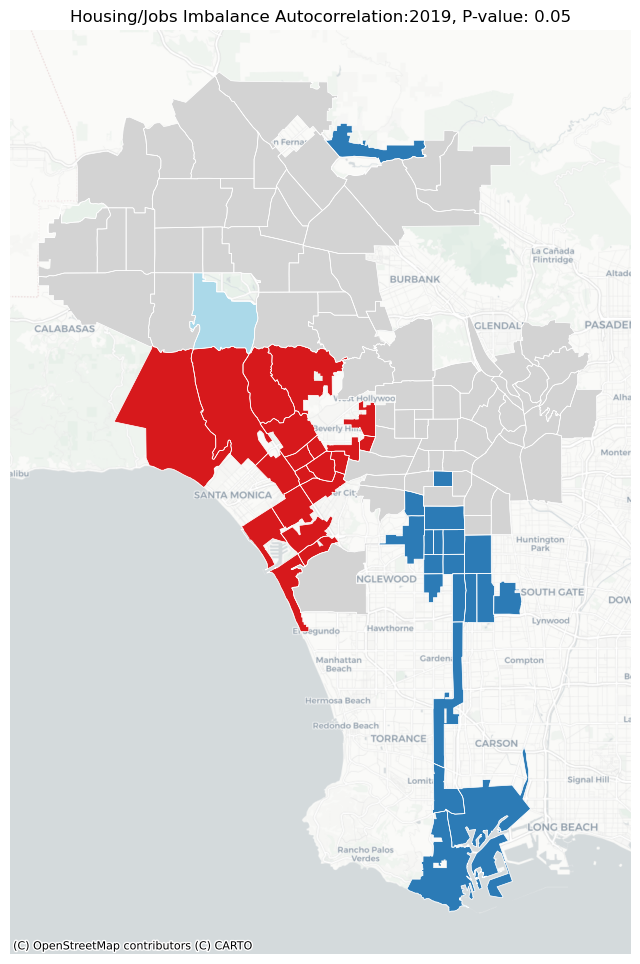

In [17]:
autocorrelate1(jh2019)



In [103]:
nhoods.head()

,external_i,location,latitude,slug_1,sqmi,display_na,set,slug,longitude,name_1,kind,type,geometry
Neighborhood,,,,,,,,,,,,,
Adams-Normandie,adams-normandie,POINT(34.031461499124156 -118.30020800000011),-118.30020800000011,None,0.805350187789,Adams-Normandie L.A. County Neighborhood (Curr...,L.A. County Neighborhoods (Current),adams-normandie,34.031461499124156,None,L.A. County Neighborhood (Current),segment-of-a-city,"MULTIPOLYGON (((-118.30901 34.03741, -118.3004..."
Arleta,arleta,POINT(34.243099999121583 -118.4307575),-118.4307575,None,3.09617917557,Arleta L.A. County Neighborhood (Current),L.A. County Neighborhoods (Current),arleta,34.243099999121583,None,L.A. County Neighborhood (Current),segment-of-a-city,"MULTIPOLYGON (((-118.42202 34.22410, -118.4228..."
Arlington Heights,arlington-heights,POINT(34.04491049912405 -118.3234085),-118.3234085,None,1.03141523527,Arlington Heights L.A. County Neighborhood (Cu...,L.A. County Neighborhoods (Current),arlington-heights,34.04491049912405,None,L.A. County Neighborhood (Current),segment-of-a-city,"MULTIPOLYGON (((-118.31591 34.05261, -118.3134..."
Atwater Village,atwater-village,POINT(34.131066356759177 -118.26237347966236),-118.26237347966236,None,1.77689394489,Atwater Village L.A. County Neighborhood (Curr...,L.A. County Neighborhoods (Current),atwater-village,34.131066356759177,None,L.A. County Neighborhood (Current),segment-of-a-city,"MULTIPOLYGON (((-118.27832 34.15301, -118.2770..."
Vermont-Slauson,vermont-slauson,POINT(33.983913999124709 -118.29035750000011),-118.29035750000011,None,1.44245256524,Vermont-Slauson L.A. County Neighborhood (Curr...,L.A. County Neighborhoods (Current),vermont-slauson,33.983913999124709,None,L.A. County Neighborhood (Current),segment-of-a-city,"MULTIPOLYGON (((-118.28061 33.99331, -118.2804..."


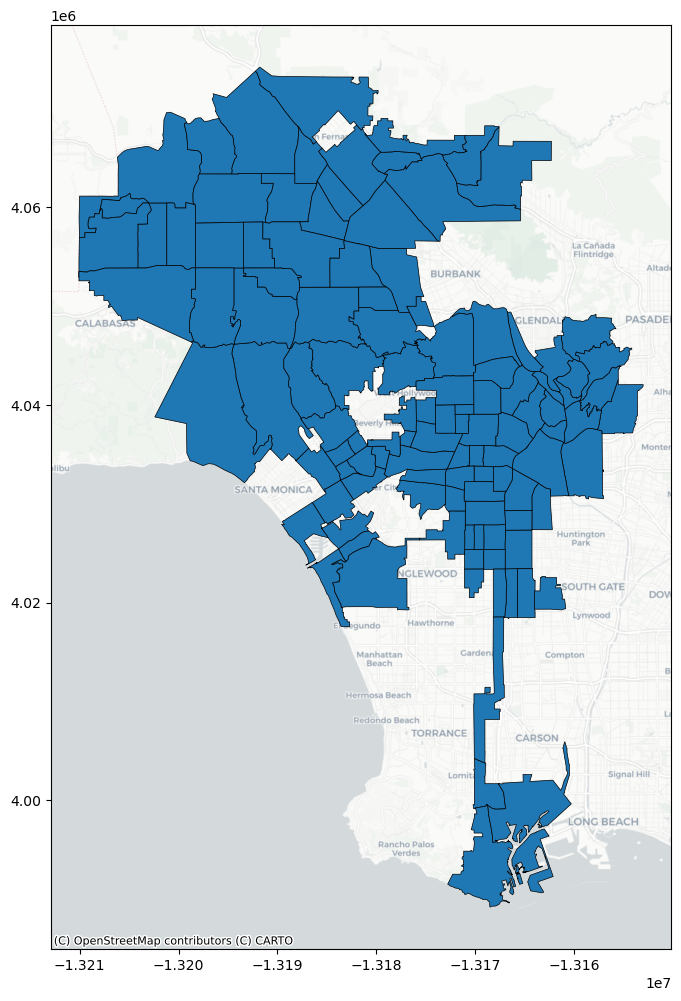

In [118]:
fig, ax1=plt.subplots(figsize=(20, 12))


cx.add_basemap(ax1,crs='EPSG:3857',source=cx.providers.CartoDB.Positron,)